<a id="top"></a>
# Spectral Products: Vegetation, Water, Urbanization

<hr>

# Notebook Summary

This notebook can be used to calculate several common spectral products from cloud-filtered Landsat mosaic images. This spectral products include: fractional cover, NDBI, NDVI, NDWI, SAVI, EVI, WOFS (Water Observations from Space algorithm from Australia). The notebook also creates a threshold product for any spectral product and can ouput results in GeoTIFF format.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Load, Clean, and Mosaic Data from the Data Cube](#load_data)
* [Fractional Cover](#frac_cov)
* [Land Spectral Indices](#land_spec_ind)
* [Water Products](#water_products)
* [Create a Threshold Plot](#theshold_plot)
* [Create GeoTIFF Output Products](#export)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
# Enable importing of utilities.
import sys
sys.path.append('..')

# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import datacube
dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np  
import xarray as xr  

import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi(config = '/home/localuser/.datacube.conf')
dc= api.dc

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [2]:
# Select a Product and Platform
# Examples: ghana, kenya, tanzania, sierra_leone, senegal

# product = "ls7_ledaps_kenya"
# platform = "LANDSAT_7"

product = "ls8_lasrc_kenya"
platform = "LANDSAT_8"

# product = "ls7_ledaps_tanzania"
# platform = "LANDSAT_7"

# product = "ls8_lasrc_tanzania"
# platform = "LANDSAT_8"

# product = "ls7_ledaps_sierra_leone"
# platform = "LANDSAT_7"


## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [3]:
# Get Coordinates of the selected cube and print them

coordinates = api.get_full_dataset_extent(platform = platform, product = product)

latitude_extents = (min(coordinates['latitude'].values),max(coordinates['latitude'].values))
longitude_extents = (min(coordinates['longitude'].values),max(coordinates['longitude'].values))
time_extents = (min(coordinates['time'].values),max(coordinates['time'].values))

print( latitude_extents )
print( longitude_extents )
print( time_extents )

(-4.997106940467012, 5.996881030410326)
(32.98674340708594, 41.9828951536269)
(numpy.datetime64('2013-04-12T07:50:21.000000000'), numpy.datetime64('2017-12-30T07:31:47.000000000'))


## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [4]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment

# Mount Kenya
# latitude = (-0.50, 0.20) 
# longitude = (37.0, 37.7) 

# Mombasa, Kenya
latitude = (-4.1, -3.9) 
longitude = (39.5, 39.7) 

# Nairobi, Kenya
# latitude = (-1.4347, -1.151) 
# longitude = (36.6985, 36.9978) 

# Kigoma, Tanzania
# latitude = (-4.95, -4.84) 
# longitude = (29.59, 29.75) 

# Dar es Salaam, Tanzania
# latitude = (-7.0, -6.7)
# longitude = (39.1, 39.4)

# Freetown, Sierra Leone
# latitude = (8.3267, 8.5123)
# longitude = (-13.3039, -13.139)

# Northern portion of Lake Naivasha, Kenya
# latitude = (-0.7355, -0.6901)
# longitude = (36.3248, 36.3735)

# Time Period
time_extents = ('2017-01-01', '2018-01-01')


In [5]:
# The code below renders a map that can be used to view the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude,longitude)

## <span id="load_data">Load, Clean, and Mosaic Data from the Data Cube [&#9652;](#top)</span>

In [6]:
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [31]:
# Displays the first few values of each data array to check the content
# Latitude and Longitude numbers = number of pixels in each dimension
# Time = number of time slices in the dataset

landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 738, longitude: 743, time: 19)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-12T07:31:47 ... 2017-12-30T07:31:47
  * latitude   (latitude) float64 -3.9 -3.9 -3.9 -3.901 ... -4.099 -4.1 -4.1
  * longitude  (longitude) float64 39.5 39.5 39.5 39.5 ... 39.7 39.7 39.7 39.7
Data variables:
    red        (time, latitude, longitude) int16 1572 1471 1457 ... 455 342 307
    green      (time, latitude, longitude) int16 1265 1253 1186 ... 573 461 424
    blue       (time, latitude, longitude) int16 761 752 692 863 ... 603 525 503
    nir        (time, latitude, longitude) int16 3754 3955 3640 ... 438 343 295
    swir1      (time, latitude, longitude) int16 3792 3765 3586 ... 446 354 292
    swir2      (time, latitude, longitude) int16 2836 2742 2656 ... 364 292 248
    pixel_qa   (time, latitude, longitude) int32 322 322 322 322 ... 328 328 352
Attributes:
    crs:      EPSG:4326

**Create 2 masks - one that only retains land, and one that retains land and water.**

In [35]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask

cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)
land_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform, cover_types=['clear'])

# Land and Water Dataset = Land and Water pixels with NO Clouds and NO Cloud Shadows
land_and_water_dataset = landsat_dataset.where(cloud_mask)

# Land Dataset = Land ONLY pixels with NO Clouds, NO Cloud Shadows and NO Water pixels
land_dataset = landsat_dataset.where(land_mask)

**Create composite "images" with mosaic functions.**

<p style="color:red";><b>CHANGE INPUTS BELOW

In [39]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic, create_max_ndvi_mosaic, create_hdmedians_multiple_band_mosaic

# Select a compositing method to create your cloud-filtered mosaic
# Remove the comments from the pair of lines under one of the mosaic types
# Options are: Median, Geomedian, or Max_NDVI 

# This is the MEDIAN mosaic
land_and_water_composite = create_median_mosaic(land_and_water_dataset, cloud_mask)
land_composite = create_median_mosaic(land_dataset, land_mask)

# This is the GEOMEDIAN mosaic
# land_and_water_composite = create_hdmedians_multiple_band_mosaic(land_and_water_dataset, cloud_mask)
# land_composite = create_hdmedians_multiple_band_mosaic(land_dataset, land_mask)

# This is the MAX_NDVI mosaic
# land_and_water_composite = create_max_ndvi_mosaic(land_and_water_dataset, cloud_mask)
# land_composite = create_max_ndvi_mosaic(land_dataset, land_mask)

cloud_mask_composite = cloud_mask.max('time')

**Show the land and water composite.**

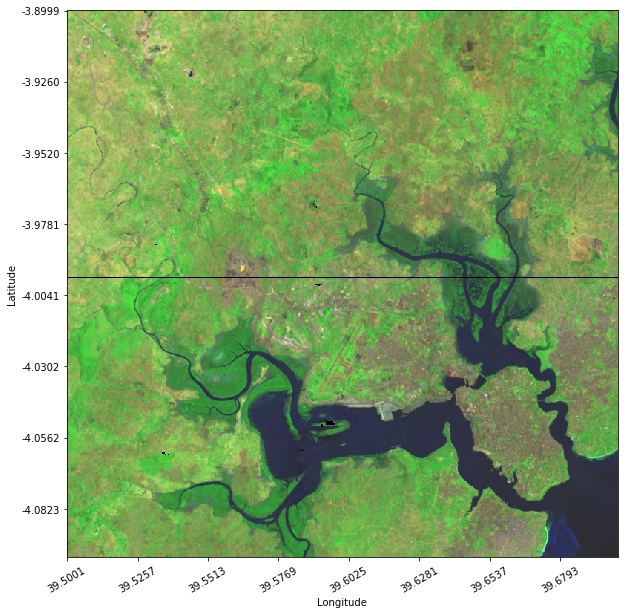

In [40]:
from utils.data_cube_utilities.dc_rgb import rgb

# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

rgb(land_and_water_composite, bands=['swir2', 'nir', 'green'], min_possible=0, max_possible=5000, width=10)
plt.show()

**Show the land-only composite (water will be removed ... black pixels).**

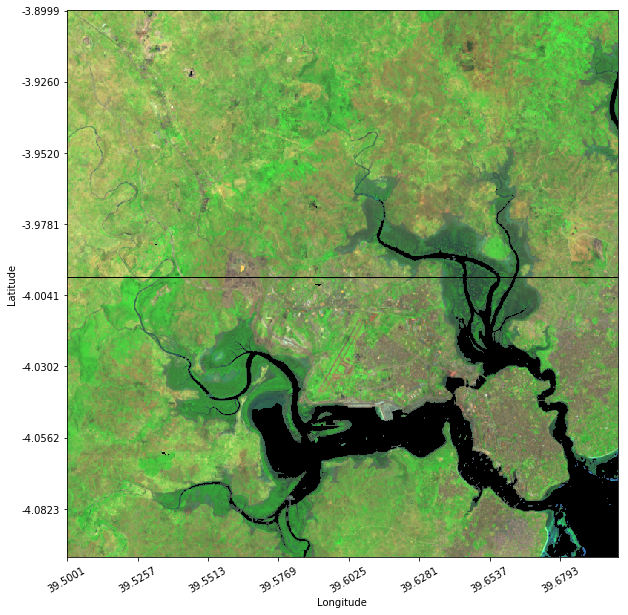

In [41]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

rgb(land_composite, bands=['swir2', 'nir', 'green'], min_possible=0, max_possible=5000, width=10)
plt.show()

## <span id="frac_cov">Fractional Cover [&#9652;](#top)</span>

Fractional Cover (FC) is used for landcover type estimation (vegetation, non-green vegetation, bare soil) of each pixel. 
<br>We use a model from CSIRO (Juan Gerschmann) and apply it to a median mosaic.  
<br>
There are 3 values for every pixel: Bare Soil (bs), Photosynthetic Vegetation (pv), and Non-Photosynthetic Vegetation (npv)
<br>
The range of each value is [0,100] - the integer percent of confidence in the pixel being the corresponding class.
<br>
Plot a False Color RGB result where RGB = bs/pv/npv

In [42]:
from utils.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
frac_classes = frac_coverage_classify(land_composite, clean_mask = np.ones(land_composite.pixel_qa.shape).astype(np.bool)) 

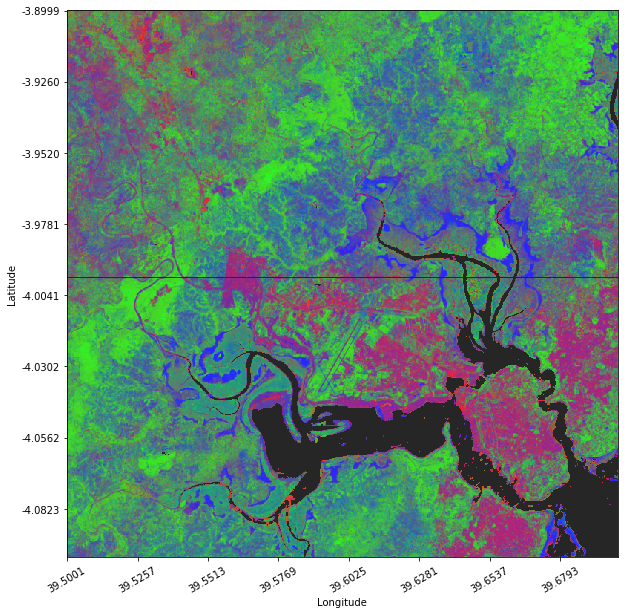

In [44]:
# Plot of Fractional Cover
# RED = Bare Soil or Urban Areas
# BLUE = Non-Green Vegetation
# GREEN = Green Vegetation
# BLACK = Water

rgb(frac_classes, bands = ['bs', 'pv', 'npv'], min_possible=0, max_possible=100) 
plt.show()

## <span id="land_spec_ind">Land Spectral Indices [&#9652;](#top)</span>

In [15]:
def NDBI(dataset):
    """
    The Normalized Difference Built-up Index (NDBI) monitors urbanization.
    Greater values generally indicate more urbanization.
    The range is [-1,1].
    """
    return (dataset.swir1 - dataset.nir)/(dataset.swir1 + dataset.nir)

In [16]:
def NDVI(dataset):
    """
    The Normalized Difference Vegetation Index (NDVI) monitors photosynthetic vegetation.
    Greater values generally indicate more photosynthetic vegetation.
    The range is [-1,1].
    """
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

In [45]:
def SAVI(ds, L=0.5, normalize=True):
    """
    The Soil-Adjusted Vegetation Index (SAVI) monitors photosyntehtic vegetation, 
    correcting for soil differences.
    Greater values generally indicate more photosynthetic vegetation.
    For Landsat data, returned values should be in the range [-1,1] if `normalize == True`.
    If `normalize == False`, returned values should be in the range [-1-L,1+L].
    """
    savi = (ds.nir - ds.red) / (ds.nir + ds.red + L) * (1 + L)
    if normalize:
        savi.values = np.interp(savi.values, (-1-L, 1+L), (-1, 1))
    return savi

In [55]:
def EVI(ds, G=2.5, C1=6, C2=7.5, L=1, normalize=True):
    """
    The 3-band Enhanced Vegetation Index (EVI). EVI is superior to NDVI in accuracy 
    because it is less dependent on the solar incidence angle, atmospheric conditions 
    (e.g. particles and clouds), shadows, and soil appearance.
    Greater values generally indicate more photosynthetic vegetation.
    The range is [-1,1] if `normalize`, and [-1,2.5] otherwise..
    """
    evi = G * (ds.nir - ds.red) / (ds.nir + C1 * ds.red - C2 * ds.blue + L)
    # Clamp values to the range [-1,2.5].
    evi.values[evi.values < -1] = -1
    evi.values[2.5 < evi.values] = 2.5
    if normalize:
        # Scale values in the  range [0,2.5] to the range [0,1].
        pos_vals_mask = 0 < evi.values
        evi.values[pos_vals_mask] = np.interp(evi.values[pos_vals_mask], (0, 2.5), (0, 1))
    return evi

In [67]:
ndbi = NDBI(land_composite)  # Normalized Difference Build Up (Urbanization) Index
ndvi = NDVI(land_composite)  # Normalized Difference Vegetation Index
ndwi = NDWI(land_composite) # Normalized Difference Water Index
ndbi2 = NDBI(land_and_water_composite)  # Normalized Difference Build Up (Urbanization) Index
ndvi2 = NDVI(land_and_water_composite)  # Normalized Difference Vegetation Index
ndwi2 = NDWI(land_and_water_composite) # Normalized Difference Water Index
savi = SAVI(land_composite)  # Soil Adjusted Vegetation Index 
evi = EVI(land_composite) # Enhanced Vegetation Index

In [68]:
ds_ndvi = ndvi2.to_dataset(name = "NDVI")
ds_ndwi = ndwi2.to_dataset(name=  "NDWI")
ds_ndbi = ndbi2.to_dataset(name = "NDBI")
normalization_dataset = ds_ndvi.merge(ds_ndwi).merge(ds_ndbi)

**Show NDBI, NDVI, NDWI False Color Composite.**

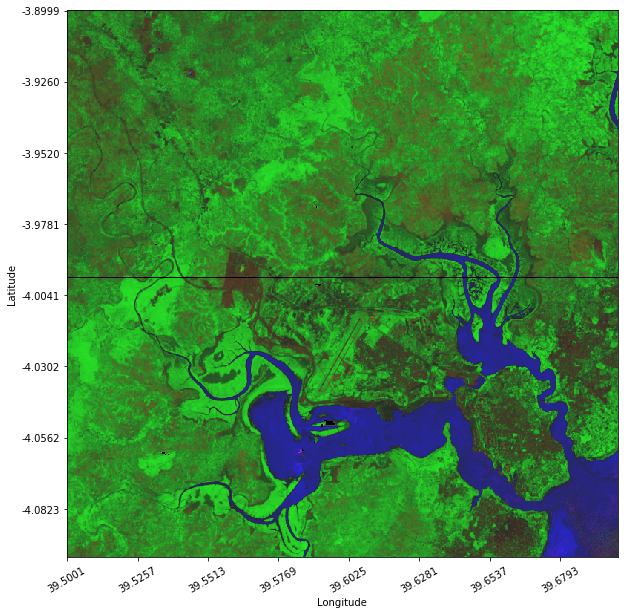

In [75]:
# Plot of RGB = NDBI-NDVI-NDWI
# RED = Bare Soil or Urban Areas
# GREEN = Vegetation
# BLUE = Water

rgb(normalization_dataset, bands = ['NDBI','NDVI','NDWI'], min_possible=0, max_possible=1.0) 
plt.show()

**Show the NDBI Composite.**

In [76]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)

Populating the interactive namespace from numpy and matplotlib


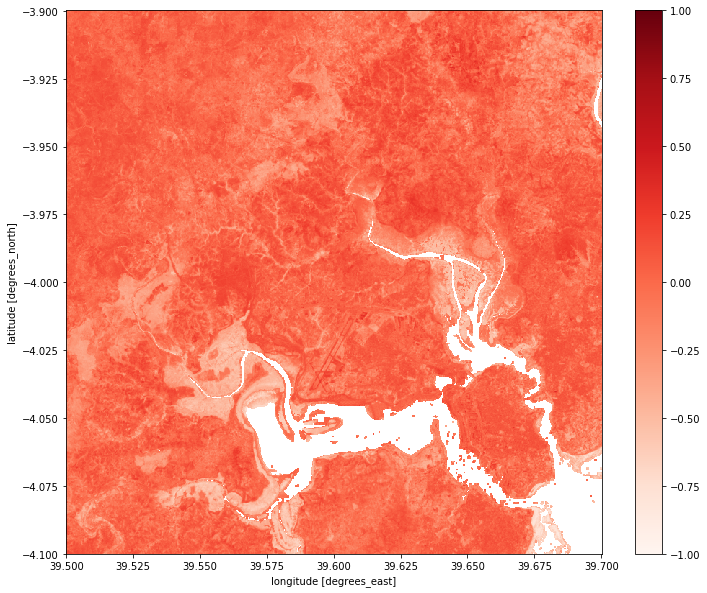

In [73]:
# May try cmap=GnBu or cmap=Greys, or cmap=Greens
(ndbi).plot(figsize=(12,10),cmap = "Reds", vmin=-1.0, vmax=1.0)
plt.show()

**Show the NDVI Composite.**

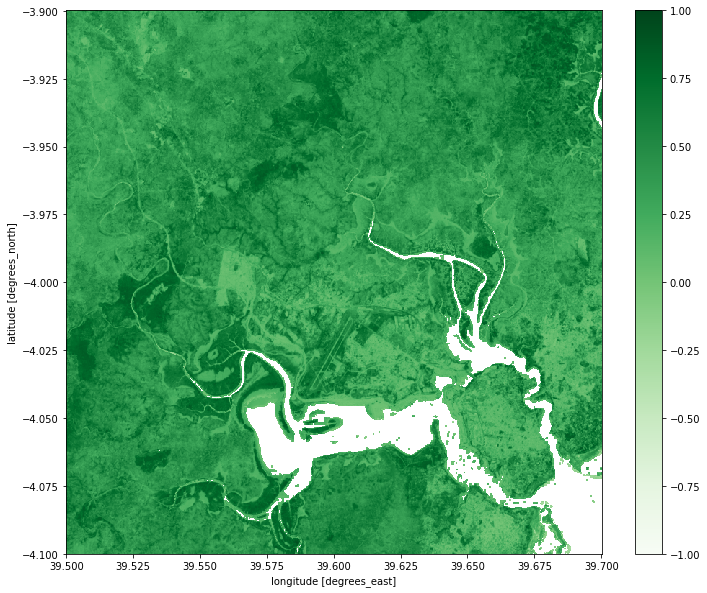

In [74]:
(ndvi).plot(figsize=(12,10), cmap = "Greens", vmin=-1.0, vmax=1.0)
plt.show()

**Show the NDVI Composite, Including Water (usually very low NDVI for water).**

In [26]:
# Create a custom colour map for NDVI
# Water (blue) = NDVI -1.0 to 0.0
# Urban or Bare Soil (brown) = NDVI 0.0 to 0.1
# Low Vegetation (tan) = NDVI 0.1 to 0.4
# Croplands (light green) = NDVI 0.4 to 0.6
# Dense Vegetation / Forests (dark green) = NDVI 0.6 to 1.0

ndvi_cmap = mpl.colors.ListedColormap(['blue', '#a52a2a','#ffffcc' ,  '#2eb82e',  '#006600'])
ndvi_bounds = [-1, 0, 0.1,  0.4,  0.6, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)

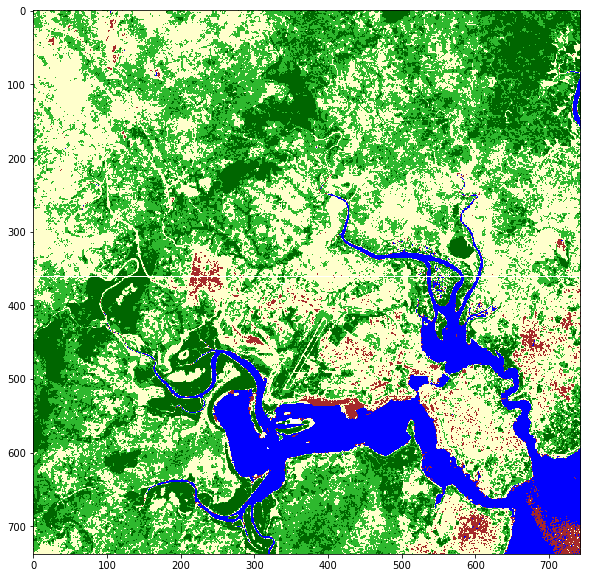

In [77]:
plt.figure(figsize=(10,10))
plt.imshow(ndvi2, cmap = ndvi_cmap, norm = ndvi_norm)
plt.show()

**Show the EVI Composite.**

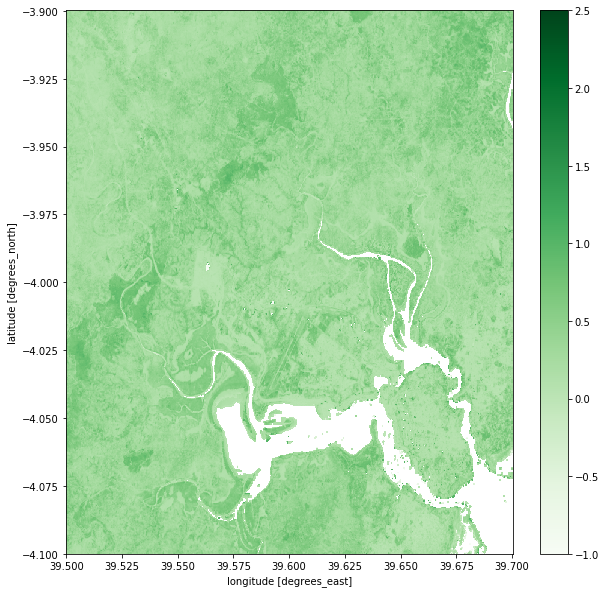

In [79]:
(evi).plot(figsize=(10,10), cmap = "Greens", vmin=-1.0, vmax=2.5)
plt.show()

**Show the SAVI Composite.**

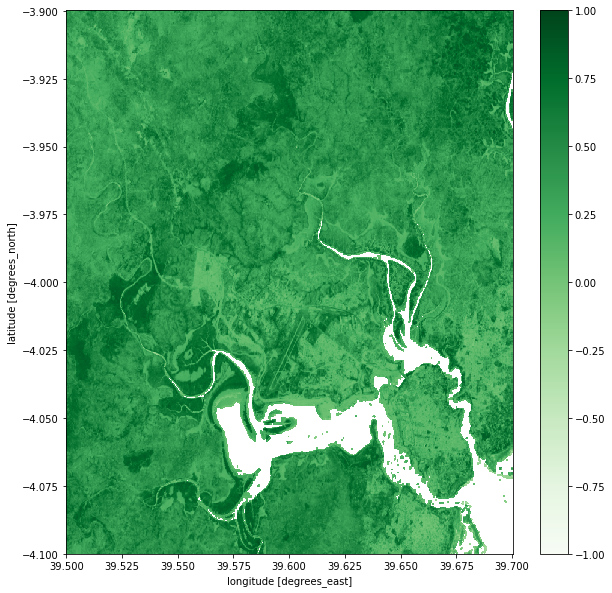

In [80]:
(savi).plot(figsize=(10,10), cmap = "Greens", vmin=-1.0, vmax=1.0)
plt.show()

## <span id="water_products">Water Products [&#9652;](#top)</span>

### Normalized Difference Water Index (NDWI)

In [88]:
def NDWI(dataset):
    """
    The Normalized Difference Water Index (NDWI) monitors water.
    Greater values generally indicate higher probability of water.
    The range is [-1,1].
    """
    return (dataset.green - dataset.nir)/(dataset.green + dataset.nir)

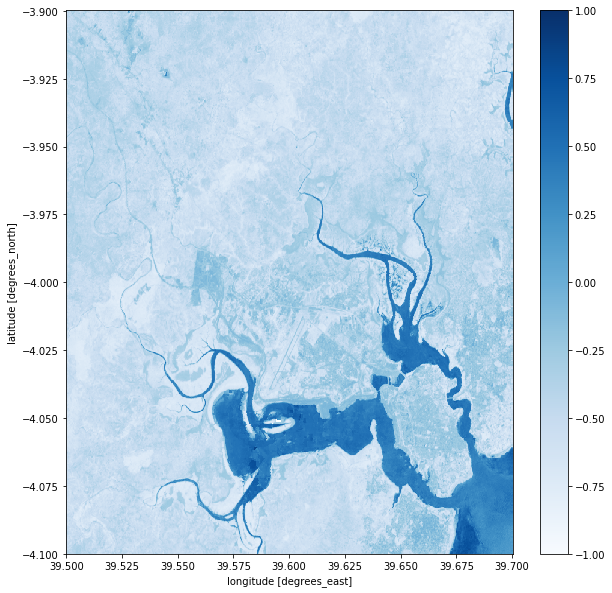

In [89]:
(ndwi2).plot(figsize=(10,10), cmap = "Blues", vmin=-1.0, vmax=1.0)
plt.show()

### Water Observation from Space (WOFS)
WOFS is a water classifier developed by Geoscience Australia

In [90]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify

In [91]:
water_classification = wofs_classify(land_and_water_composite, mosaic = True) 

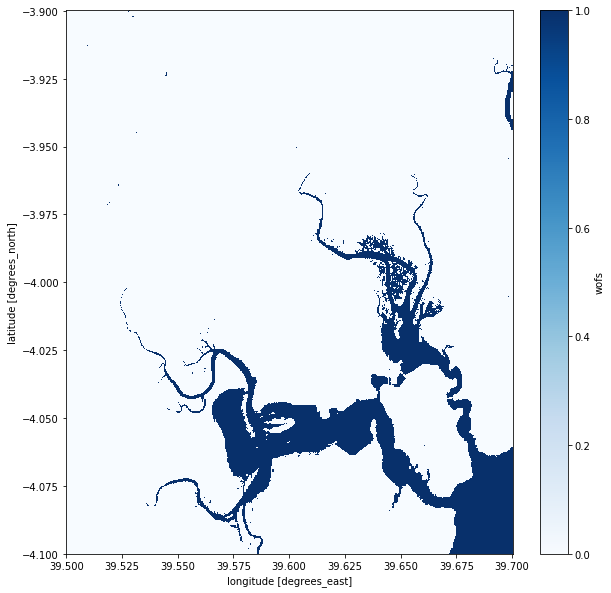

In [92]:
# Plot of WOFS product
# BLUE = 1.0 = Water
# WHITE = 0.0 = Non-Water

water_classification.wofs.plot(cmap='Blues')
plt.show()

## <span id="theshold_plot">Create a Threshold Plot [&#9652;](#top)</span>
First we will define a minimum threshold and a maximum threshold. Then you will create a plot that colors the region between the threshold a single color (e.g. red) and the region outside the threshold will be BLACK or WHITE. Also, we will calculate the % of pixels and the number of pixels in the threshold range.

In [94]:
from matplotlib.ticker import FuncFormatter

def threshold_plot(da, min_threshold, max_threshold, mask = None, width = 10, *args, **kwargs): 
    color_in    = np.array([255,0,0])
    color_out   = np.array([0,0,0])
    color_cloud = np.array([255,255,255])
    
    array = np.zeros((*da.values.shape, 3)).astype(np.int16)
    
    inside  = np.logical_and(da.values > min_threshold, da.values < max_threshold)
    outside = np.invert(inside)
    masked  = np.zeros(da.values.shape).astype(bool) if mask is None else mask
    
    array[inside] =  color_in
    array[outside] = color_out
    array[masked] =  color_cloud

    def figure_ratio(ds, fixed_width = 10):
        width = fixed_width
        height = len(ds.latitude) * (fixed_width / len(ds.longitude))
        return (width, height)


    fig, ax = plt.subplots(figsize = figure_ratio(da,fixed_width = width))
    
    lat_formatter = FuncFormatter(lambda y_val, tick_pos: "{0:.3f}".format(da.latitude.values[tick_pos] ))
    lon_formatter = FuncFormatter(lambda x_val, tick_pos: "{0:.3f}".format(da.longitude.values[tick_pos]))

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    plt.title("Threshold: {} < x < {}".format(min_threshold, max_threshold))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.imshow(array, *args, **kwargs)
    plt.show()

<p style="color:red";><b>CHANGE INPUTS BELOW

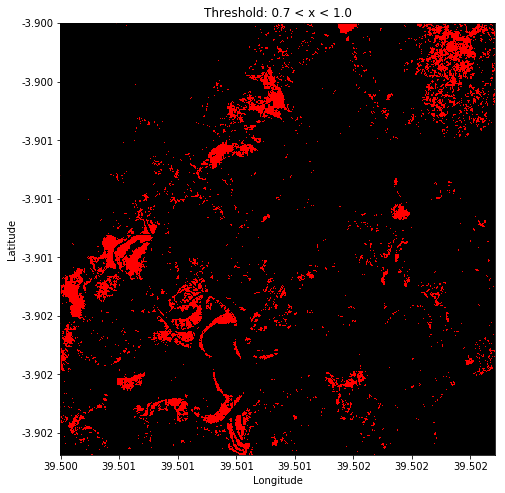

In [96]:
# Select a threshold range for your spectral variable and generate a plot.
# Remove comments from the set of 3 lines for your desired variable.
# Variable choices are NDBI, NDVI, EVI, SAVI, FC-Bare Soil, FC-Photosynthetic Vegetation.

# NDBI (Buildup Index) = -1.0 to 1.0 (full range)
# NDBI 0.0 to 0.2 is typical for urban areas
# -----------------------
# minimum_threshold = 0.0
# maximum_threshold = 0.3
# threshold_plot(ndbi, minimum_threshold, maximum_threshold, width = 8)

# NDVI (Vegetation Index) = -1.0 to 1.0
# NDVI < 0.0 = non-vegetation (bare soil)
# NDVI 0.2 to 0.6 = grasslands
# NDVI 0.6 to 0.9 = dense vegetation / trees
# -----------------------
minimum_threshold = 0.7
maximum_threshold = 1.0
threshold_plot(ndvi, minimum_threshold, maximum_threshold, width = 8)

# EVI (Vegetation Index) = -1.0 to 2.5
# EVI 2.0 to 2.5 is typical for dense vegetation
# -----------------------
# minimum_threshold = 2.0
# maximum_threshold = 2.5
# threshold_plot(evi, minimum_threshold, maximum_threshold, width = 8)

# SAVI (Vegetation Index) = -1.0 to 1.0
# -----------------------
# minimum_threshold = 0.6
# maximum_threshold = 0.9
# threshold_plot(savi, minimum_threshold, maximum_threshold, width = 8)

# Fractional Cover (pv,npv,bs) = 0 to 100
# Bare Soil (bs) >40 = urbanization / bare soil
# ----------------------
# minimum_threshold = 40.0
# maximum_threshold = 100.0
# threshold_plot(frac_classes.bs, minimum_threshold, maximum_threshold, width = 8)

# Fractional Cover (pv,npv,bs) = 0 to 100
# Photosynthetic Vegetation (pv) >80 = dense green vegetation
# ----------------------
# minimum_threshold = 80.0
# maximum_threshold = 100.0
# threshold_plot(frac_classes.pv, minimum_threshold, maximum_threshold, width = 8)


In [97]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask.values)
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))


<p style="color:red";><b>CHANGE INPUTS BELOW

In [98]:
# Select a threshold statistical function that matches your land spectral variable
# COUNT = number of pixels in each category
# PERCENTAGE = percent of pixels in each category
# ---------------------------------

# NDBI Threshold
threshold_count(ndbi,minimum_threshold,maximum_threshold, cloud_mask_composite)
# threshold_percentage(ndbi,minimum_threshold,maximum_threshold)

# NDVI Threshold
# threshold_count(ndvi,minimum_threshold,maximum_threshold)
# threshold_percentage(ndvi,minimum_threshold,maximum_threshold)

# EVI Threshold
# threshold_count(evi,minimum_threshold,maximum_threshold)
# threshold_percentage(evi,minimum_threshold,maximum_threshold)

# SAVI Threshold
# threshold_count(savi,minimum_threshold,maximum_threshold)
# threshold_percentage(savi,minimum_threshold,maximum_threshold)

# Fractional Cover - Bare Soil
# threshold_count(frac_classes.bs, minimum_threshold, maximum_threshold)
# threshold_percentage(frac_classes.bs, minimum_threshold, maximum_threshold)

# Fractional Cover - Photosynthetic Vegetation
# threshold_count(frac_classes.pv, minimum_threshold, maximum_threshold)
# threshold_percentage(frac_classes.pv, minimum_threshold, maximum_threshold)


{'total': 548334, 'total_non_cloudy': 547482, 'inside': 0, 'outside': 547482}

In [99]:
threshold_percentage(ndbi,minimum_threshold,maximum_threshold)

{'percent_inside_threshold': 0.0,
 'percent_outside_threshold': 92.18469035296005,
 'percent_clouds': 7.815309647039953}

### Water Counts

In [100]:
# NDWI value for water = 0.0 to 1.0

ndwi_minimum_threshold = 0.0
ndwi_maximum_threshold = 1.0

<p style="color:red";><b>CHANGE INPUTS BELOW

In [101]:
# Select a threshold "count" or "percentage" statistical result
# COUNT = number of pixels in each category
# PERCENTAGE = percent of pixels in each category

threshold_count(ndwi,ndwi_minimum_threshold,ndwi_maximum_threshold, cloud_mask_composite)
# threshold_percentage(ndwi,ndwi_minimum_threshold,ndwi_maximum_threshold)

{'total': 548334, 'total_non_cloudy': 547482, 'inside': 813, 'outside': 546669}

In [102]:
threshold_percentage(ndwi,ndwi_minimum_threshold,ndwi_maximum_threshold, cloud_mask_composite)

{'percent_inside_threshold': 0.14826729693945662,
 'percent_outside_threshold': 99.69635295276237,
 'percent_clouds': 0.15537975029818085}

In [103]:
# WOFS value for water = 0.0 or 1.0
# The threshold uses a range of 0.9 to 1.1 to identify water (1.0)

wofs_minimum_threshold = 0.0
wofs_maximum_threshold = 1.0

<p style="color:red";><b>CHANGE INPUTS BELOW

In [104]:
# Select a threshold "count" or "percentage" statistical result
# COUNT = number of pixels in each category
# PERCENTAGE = percent of pixels in each category

threshold_count(water_classification.wofs,wofs_minimum_threshold,wofs_maximum_threshold, cloud_mask_composite)
# threshold_percentage(water_classification.wofs,wofs_minimum_threshold,wofs_maximum_threshold)

{'total': 548334, 'total_non_cloudy': 547482, 'inside': 0, 'outside': 547482}

In [105]:
threshold_percentage(water_classification.wofs,wofs_minimum_threshold,wofs_maximum_threshold, cloud_mask_composite)

{'percent_inside_threshold': 0.0,
 'percent_outside_threshold': 99.84462024970182,
 'percent_clouds': 0.15537975029818085}

## <span id="export">Create GeoTIFF Output Products [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [111]:
from utils.data_cube_utilities_special.dc_utilities import write_geotiff_from_xr

# Remove the comment to create a GeoTIFF output product
# Change the name of the output file, or it will be overwritten for each run 
# Change the desired bands at the end of the function

# Fractional Coverage
# write_geotiff_from_xr("geotiffs/frac_classes.tif", frac_classes, bands=['bs'])

# NDVI
# write_geotiff_from_xr("geotiffs/ndvi_land.tif", ndvi)

# SAVI
# write_geotiff_from_xr("geotiffs/savi.tif", savi)

# EVI
# write_geotiff_from_xr("geotiffs/evi.tif", evi)

# WOFS
write_geotiff_from_xr("geotiffs/wofs.tif", water_classification.wofs)

In [112]:
!ls -lah geotiffs/*.tif

-rw-rw-r-- 1 localuser localuser 833M Apr 14 23:52 geotiffs/WOFS_Percentage_L-BIG_AC.tif
-rw-rw-r-- 1 localuser localuser 123M Apr 11 12:36 geotiffs/WOFS_Percentage_L-Turkana_AC.tif
-rw-rw-r-- 1 localuser localuser  53M Apr 11 10:09 geotiffs/WOFS_Percentage_L-Victoria_AC.tif
-rw-rw-r-- 1 localuser localuser  34K Dec 19 20:38 geotiffs/WOFS_Percentage_demo.tif
-rw-rw-r-- 1 localuser localuser 9.5M Mar 12 00:48 geotiffs/WOFS_Percentage_demo2.tif
-rw-rw-r-- 1 localuser localuser 4.2M Dec 22 22:33 geotiffs/evi.tif
-rw-rw-r-- 1 localuser localuser  17M May  6 18:20 geotiffs/frac_classes.tif
-rw-rw-r-- 1 localuser localuser 4.2M Dec 22 22:33 geotiffs/ndvi_land.tif
-rw-rw-r-- 1 localuser localuser 4.2M Dec 22 22:33 geotiffs/ndvi_land_and_water.tif
-rw-rw-r-- 1 localuser localuser 4.7M May  7 18:23 geotiffs/sample_anomaly_01.tif
-rw-rw-r-- 1 localuser localuser 4.2M Dec 22 22:33 geotiffs/savi.tif
-rw-rw-r-- 1 localuser localuser 4.2M May  7 21:54 geotiffs/wofs.tif
